Osnabrück University - Machine Learning (Summer Term 2019) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 08

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, June 1, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Conditional Probability) [2 Points]

This exercise is supposed to be very easy and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** Explain the idea of conditional probability. How is it defined?

YOUR ANSWER HERE

**b)** What is Bayes' theorem? What are its applications?

YOUR ANSWER HERE

**c)** What does the law of total probability state? 

YOUR ANSWER HERE

## Assignment 1: Multilayer Perceptron (MLP) [10 Points]

Last week you implemented a simple perceptron. We discussed that one can use multiple perceptrons to build a network. This week you will build your own MLP. Again the following code cells are just a guideline. If you feel like it, just follow the algorithm steps and implement the MLP yourself.

### Implementation

In the following you will be guided through implementing an MLP step by step. Instead of sticking to this guide, you are free to take a complete custom approach instead if you wish.

We will take a bottom-up approach: Starting from an individual **perceptron** (aka neuron), we will derive a **layer of perceptrons** and end up with a **multilayer perceptron** (aka neural network). Each step will be implemented as its own python *class*. Such a class defines a type of element which can be instantiated multiple times. You can think of the relation between such instances and their designated classes as individuals of a specific population (e.g. Bernard and Bianca are both individuals of the population mice). Class definitions contain methods, which can be used to manipulate instance of that class or to make it perform specific actions — again, taking the population reference, each mouse of the mice population would for example have the method `eat_cheese()`.

To guide you along, all required classes and functions are outlined in valid python code with extensive comments. You just need to fill in the gaps. For each method the [docstring](https://www.python.org/dev/peps/pep-0257/#what-is-a-docstring) (the big comment contained by triple quotes at the beginning of the method) describes the arguments that each specific method accepts (`Args`) and the values it is expected to return (`Returns`).

### Perceptron
Similar to last week you here need to implement a perceptron. But instead of directly applying it, we will define a class which is reusable to instantiate a theoretically infinite amount of individual perceptrons. We will need the following three functionalities:

#### Weight initialization

The weights are initialized by sampling values from a standard normal distribution. There are as many weights as there are values in the input vector and an additional one for the perceptron's bias.

#### Forward-Propagation / Activation

Calculate the weighted sums of a neuron's inputs and apply it's activation function $\sigma$. The output vector $o$ of perceptron $j$ of layer $k$ given an input $x$ (the output of the previous layer) in a neural network is given by the following formula. Note: $N$ gives the number of values of a given vector, $w_{j,0}(k)$ specifies the bias of perceptron $j$ in layer $k$ and $w_{j,1...N(x)}(k)$ the other weights of perceptron $j$ in layer $k$.

$$o_{k,j}(x) = \sigma\left(w_{j,0}(k)+\sum\limits_{i=1}^{N(x)} x_i w_{j,i}(k)\right)$$

Think of the weights $w(k)$ as a matrix being located in-between layer $k$ and the layer located *to its left* in the network. So values flowing from layer $k-1$ to layer $k$ are weighted by the values of $w(k)$. As activation function we will use the sigmoid function because of its nice derivative (needed later):

$$\begin{align*}
\sigma(x) &= \frac{1}{1 + \exp{(-x)}}\\
\frac{d\sigma}{dx}(x) &= \sigma(x) \cdot (1 - \sigma(x))
\end{align*}$$

#### Back-Propagation / Adaptation
In order to learn something the perceptron needs to slowly adjust its weights. Each weight $w_{j,i}$ in layer $k$ is adjusted by a value $\Delta w_{j,i}$ given a learning rate $\epsilon$, the previous layer's output (or, for the first hidden layer, the network's input) $o_{k-1,i}(x)$ and the layer's error signals $\delta(k)$ (which will be calculated by the MultilayerPerceptron):

$$\Delta w_{j,i}(k) = \epsilon\, \delta_j(k) o_{k-1,i}(x)$$

In [1]:
import numpy as np

# Activation function σ.
# We use scipy's builtin because it fixes some NaN problems for us.
# sigmoid = lambda x: 1 / (1 + np.exp(-x))
from scipy.special import expit as sigmoid


class Perceptron:
    """Single neuron handling its own weights and bias."""

    def __init__(self, dim_in, act_func=sigmoid):
        """Initialize a new neuron with its weights and bias.

        Args:
            dim_in (int): Dimensionality of the data coming into this perceptron. 
                In a network of perceptrons this basically represents the 
                number of neurons in the layer before this neuron's layer. 
                Used for generating the perceptron's weights vector, which 
                not only includes one weight per input but also an additional 
                bias weight.
            act_fun (function): Function to apply on activation.
        """
        self.act_func = act_func
        self.weights = np.random.normal(size=(dim_in+1))

    def activate(self, x):
        """Activate this neuron with a specific input.

        Calculate the weighted sum of inputs and apply the activation function.

        Args:
            x (ndarray): Vector of input values.

        Returns:
            float: A real number representing the perceptron's activation after 
            calculating the weighted sum of inputs and applying the 
            perceptron's activation function.
        """
        # Return the activation value
        return self.act_func(self.weights[0]+x@self.weights[1:])

    def adapt(self, x, delta, rate=0.03):
        """Adapt this neuron's weights by a specific delta.

        Args:
            x (ndarray): Vector of input values.
            delta (float): Weight adaptation delta value.
            rate (float): Learning rate.
        """
        # Adapt self.weights according to the update rule
        self.weights += rate*delta*np.array([1,*x])

_p = Perceptron(2)
assert _p.weights.size == 3, "Should have a weight per input and a bias."
assert isinstance(_p.activate([2, 1]), float), "Should activate as scalar."
assert -1 <= _p.activate([100, 100]) <= 1, "Should activate using sigmoid."
_p.weights = np.array([.5, .5, .5])
_p.adapt([2, 3], np.array(.5))
assert np.allclose(_p.weights, [0.515, 0.53, 0.545]), \
        "Should update weights correctly."

### PerceptronLayer
A `PerceptronLayer` is a combination of multiple `Perceptron` instances. It mainly is concerened with passing input and delta values to its individual neurons. There is no math to be done here!

#### Initialization

When initializing a `PerceptronLayer` (like this: `layer = PerceptronLayer(5, 3)`), the `__init__` function is called. It creates a list of `Perceptron`s: For each output value there must be one perceptron. Each of those perceptrons receives the same inputs and the same activation function as the perceptron layer.

#### Activation

During the activation step, the perceptron layer activates each of its perceptrons. These values will not only be needed for forward propagation but will also be needed for implementing backpropagation in the `MultilayerPerceptron` (coming up next).

#### Adaptation

To update its perceptrons, the perceptron layer adapts each one with the corresponding delta. For this purpose, the MLP passes a list of input values and a list of deltas to the adaptation function. The inputs are passed to *all* perceptrons. The list of deltas is exactly as long as the list of perceptrons: The first delta is for the first perceptron, the second for the second, etc. The delta values themselves will be computed by the MLP.

In [4]:
class PerceptronLayer:
    """Layer of multiple neurons.
    
    Attributes:
        perceptrons (list): List of perceptron instances in the layer.
    """
    def __init__(self, dim_in, dim_out, act_func=sigmoid):
        """Initialize the layer as a list of individual neurons.

        A layer contains as many neurons as it has outputs, each
        neuron has as many input weights (+ bias) as the layer has inputs.

        Args:
            dim_in (int): Dimensionality of the expected input values,
                also the size of the previous layer of a neural network.
            dim_out (int): Dimensionality of the output, also the requested 
                amount of in this layer and the input dimension of the
                next layer.
            act_func (function): Activation function to use in each perceptron of
                this layer.
        """
        # Set self.perceptrons to a list of Perceptrons
        self.perceptrons = [Perceptron(dim_in, act_func=act_func) for i in range(dim_out)]
        

    def activate(self, x):
        """Activate this layer by activating each individual neuron.

        Args:
            x (ndarray): Vector of input values.

        Retuns:
            ndarray: Vector of output values which can be 
            used as input to another PerceptronLayer instance.
        """
        # return the vector of activation values
        out = np.array([perc.activate(x) for perc in self.perceptrons])
        return out

    def adapt(self, x, deltas, rate=0.03):
        """Adapt this layer by adapting each individual neuron.

        Args:
            x (ndarray): Vector of input values.
            deltas (ndarray): Vector of delta values.
            rate (float): Learning rate.
        """
        # Update all the perceptrons in this layer
        for i in range(len(self.perceptrons)):
            self.perceptrons[i].adapt(x, deltas[i], rate=rate)
        
    @property
    def weight_matrix(self):
        """Helper property for getting this layer's weight matrix.

        Returns:
            ndarray: All the weights for this perceptron layer.
        """
        return np.asarray([p.weights for p in self.perceptrons]).T


_l = PerceptronLayer(3, 2)
assert len(_l.perceptrons) == 2, "Should have as many perceptrons as outputs."
assert len(_l.activate([1,2,3])) == 2, "Should provide correct output amount."

### MultilayerPerceptron

#### Forward-Propagation / Activation
Propagate the input value $x$ through each layer of the network, employing the output of the previous layer as input to the next layer.

#### Back-Propagation / Adaptation
This is the most complex step of the whole task. Split into three separate parts:

1. ***Forward propagation***: Compute the outputs for each individual layer – similar to the forward-propagation step above, but we need to keep track of the intermediate results to compute each layer's errors. That means: Store the input as the first "output" and then activate each of the network's layers using the *previous* layer's output and store the layer's activation result.

2. ***Backward propagation***: Calculate each layer's error signals $\delta_i(k)$. The important part here is to do so from the last to the first array, because each layer's error depends on the error from its following layer. Note: The first part of this formula makes use of the activation functions derivative $\frac{d\sigma}{dx}(k)$.

    $$\delta_i(k) = o_i(k)\ (1 - o_i(k))\ \sum\limits_{j=1}^{N(k+1)} w_{ji}(k+1,k)\delta_j(k+1)$$

    (*Hint*: For the last layer (i.e. the first you calculate the $\delta$ for) the sum in the formula above is the total network error. For all preceding layers $k$ you need to recalculate `e` using the $\delta$ and weights of layer $k+1$. We already implemented a helper function for you to access the weights of a specific layer. Check the `PerceptronLayer` if you did not find it yet.)

3. ***Adaptation***: Call each layers adaptation function with its input, its designated error signals and the given learning rate.

Hint: The last two steps can be performed in a single loop if you wish, but make sure to use the non-updated weights for the calculation of the next layer's error signals!

In [5]:
class MultilayerPerceptron:
    """Network of perceptrons, also a set of multiple perceptron layers.
    
    Attributes:
        layers (list): List of perceptron layers in the network.
    """
    def __init__(self, *layers):
        """Initialize a new network, madeup of individual PerceptronLayers.

        Args:
            *layers: Arbitrarily many PerceptronLayer instances.
        """
        self.layers = layers

    def activate(self, x):
        """Activate network and return the last layer's output.

        Args:
            x (ndarray): Vector of input values.

        Returns:
            (ndarray): Vector of output values from the last layer of the 
            network after propagating forward through the network.
        """
        # Propagate activation through the network
        # and return output for last layer
        for layer in self.layers:
            x = layer.activate(x)
        return x
        

            

    def adapt(self, x, t, rate=0.03):
        """Adapt the whole network given an input and expected output.

        Args:
            x (ndarray): Vector of input values.
            t (ndarray): Vector of target values (expected outputs).
            rate (float): Learning rate.
        """
        # Activate each layer and collect intermediate outputs.
        outputs = [x]
        for i, layer in enumerate(self.layers):
            result = layer.activate(outputs[i])
            outputs.append(result)
        
        # Calculate error 'e' between t and network output.
        e = t - outputs[-1]
        #print('e',e)
        
        # Backpropagate error through the network computing
        # intermediate delta and adapting each layer.
        for i in range(len(self.layers)):
            deltas = outputs[-(i+1)]*(1-outputs[-(i+1)])*e
            e = self.layers[-(i+1)].weight_matrix[1:]@deltas
            #print('x', x)
            self.layers[-(i+1)].adapt(outputs[-(i+2)], deltas, rate)
            
        

### Classification

#### Problem Definition
Before we start, we need a problem to solve. In the following cell we first generate some three dimensional data (= $\text{input_dim}$) between 0 and 1 and label all data according to a binary classification: If the data is close to the center (radius < 2.5), it belongs to one class, if it is further away from the center it belongs to the other class.

In the cell below we visualize the data set.

In [6]:
def uniform(a, b, n=1):
    """Returns n floats uniformly distributed between a and b."""
    return (b - a) * np.random.random_sample(n) + a


n = 1000
radius = 5
r = np.append(uniform(0, radius * .5, n // 2),
              uniform(radius * .7, radius, n // 2))
angle = uniform(0, 2 * np.pi, n)
x = r * np.sin(angle) + uniform(-radius, radius, n)
y = r * np.cos(angle) + uniform(-radius, radius, n)
inputs = np.vstack((x, y)).T
targets = np.less(np.linalg.norm(inputs, axis=1), radius * .5)

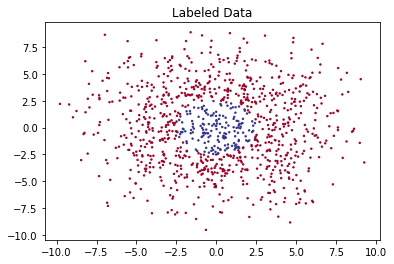

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(num='Data')
ax.set(title='Labeled Data')
ax.scatter(*inputs.T, 2, c=targets, cmap='RdYlBu')
plt.show()

### Model Design
The following cell already contains a simple model with a single layer. Play around with some different configurations!

In [8]:
MLP = MultilayerPerceptron(
    PerceptronLayer(2,3),PerceptronLayer(3, 1),
)
# Adapt this MLP
# YOUR CODE HERE

### Training
Train the network on random samples from the data. Try adjusting the epochs and watch the training performance closely using different models.

<IPython.core.display.Javascript object>


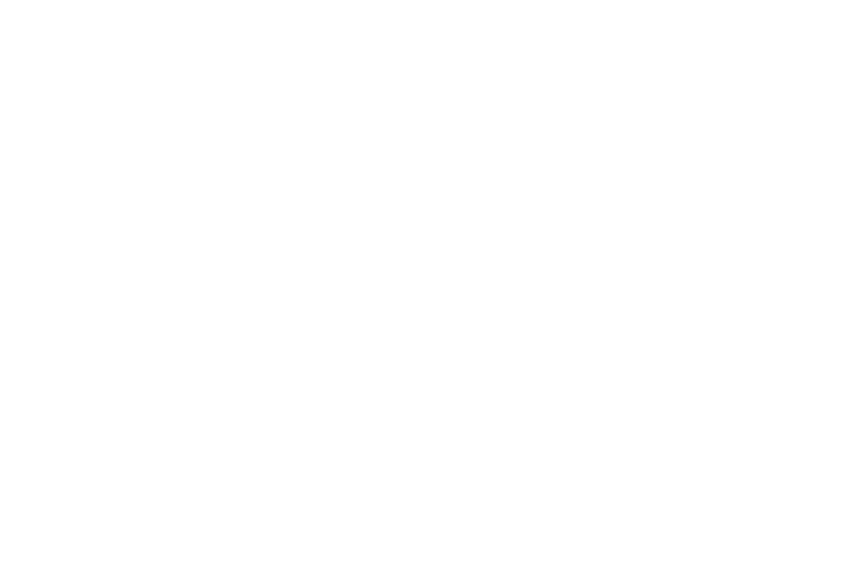

<IPython.core.display.Javascript object>


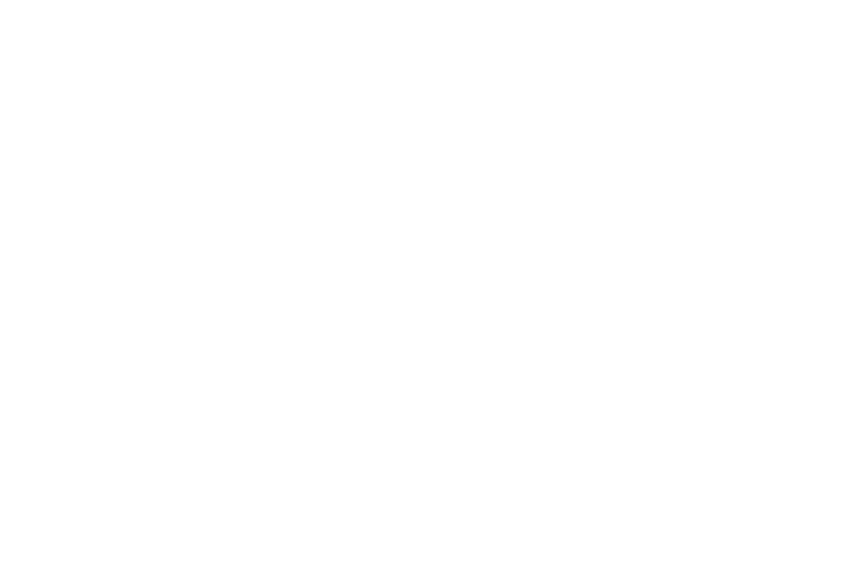

In [9]:
%matplotlib notebook
from matplotlib import cm

EPOCHS = 200000

max_accuracy = 0

fig, ax = plt.subplots(num='Training')
scatter = ax.scatter(*inputs.T, 2)
plt.show()

for epoch in range(1, EPOCHS + 1):
    sample_index = np.random.randint(0, len(targets))
    MLP.adapt(inputs[sample_index], targets[sample_index])

    if (epoch % 2500) == 0:
        outputs = np.squeeze([MLP.activate(x) for x in inputs])
        predictions = np.round(outputs)
        accuracy = np.sum(predictions == targets) / len(targets) * 100
        if accuracy > max_accuracy:
            max_accuracy = accuracy
        scatter.set_color(cm.RdYlBu(outputs))
        ax.set(title=f'Training {epoch / EPOCHS * 100:.0f}%: {accuracy:.2f}%. Best accuracy: {max_accuracy:.2f}%')
        fig.canvas.draw()

### Evaluation

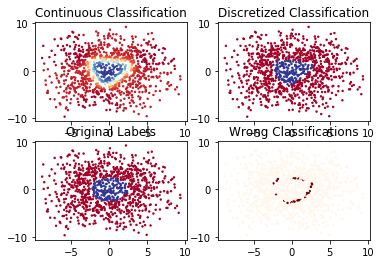

In [168]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0, 0].scatter(*inputs.T, 2, c=outputs, cmap='RdYlBu')
ax[0, 0].set_title('Continuous Classification')
ax[0, 1].set_title('Discretized Classification')
ax[0, 1].scatter(*inputs.T, 2, c=np.round(outputs), cmap='RdYlBu')
ax[1, 0].set_title('Original Labels')
ax[1, 0].scatter(*inputs.T, 2, c=targets, cmap='RdYlBu')
ax[1, 1].set_title('Wrong Classifications')
ax[1, 1].scatter(*inputs.T, 2, c=(targets != np.round(outputs)), cmap='OrRd')
plt.show()

## Results
Document your results in the following cell. We are interested in which network configurations you tried and what accuracies they resulted in. Did you run into problems during training? Was it steady or did it get stuck? Did you recognize anything about the training process? How could we get better results? Tell us!

When we train the network with only one layer the data cannot be separated properly, because the data requieres a non-linear separatrix. with two layers the data can be separated with high accuracy.

## Assignment 2: MLP and RBFN [10 Points]

This exercise is aimed at deepening the understanding of Radial Basis Function Networks and how they relate to Multilayer Perceptrons. Not all of the answers can be found directly in the slides - so when answering the (more algorithmic) questions, first take a minute and think about how you would go about solving them and if nothing comes to mind search the internet for a little bit. If you are interested in a real life application of both algorithms and how they compare take a look at this paper: [Comparison between Multi-Layer Perceptron and Radial Basis Function Networks for Sediment Load Estimation in a Tropical Watershed](http://file.scirp.org/pdf/JWARP20121000014_80441700.pdf)

![Schematic of a RBFN](RBFN.png)

We have prepared a little example that shows how radial basis function approximation works in Python. This is not an example implementation of a RBFN but illustrates the work of the hidden neurons.

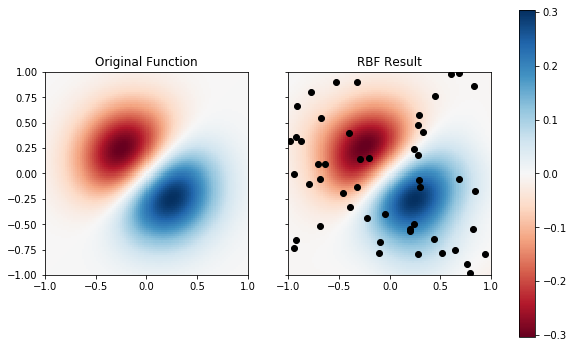

In [178]:
%matplotlib inline
import numpy as np
from numpy.random import uniform

from scipy.interpolate import Rbf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm


def func(x, y):
    """
    This is the example function that should be fitted.
    Its shape could be described as two peaks close to
    each other - one going up, the other going down
    """
    return (x + y) * np.exp(-4.0 * (x**2 + y**2))


# number of training points (you may try different values here)
training_size = 50

# sample 'training_size' data points from the input space [-1,1]x[-1,1] ...
x = uniform(-1.0, 1.0, size=training_size)
y = uniform(-1.0, 1.0, size=training_size)

# ... and compute function values for them.
fvals = func(x, y)

# get the aprroximation via RBF
new_func = Rbf(x, y, fvals)


# Plot both functions:
# create a 100x100 grid of input values
x_grid, y_grid = np.mgrid[-1:1:100j, -1:1:100j]

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 6))
# This plot represents the original function
f_orig = func(x_grid, y_grid)
img = ax[0].imshow(f_orig, extent=[-1, 1, -1, 1], cmap='RdBu')
ax[0].set(title='Original Function')
# This plots the approximation of the original function by the RBF
# if the plot looks strange try to run it again, the sampling
# in the beginning is random
f_new = new_func(x_grid, y_grid)
plt.imshow(f_new, extent=[-1, 1, -1, 1], cmap='RdBu')
ax[1].set(title='RBF Result', xlim=[-1, 1], ylim=[-1, 1])
# scatter the datapoints that have been used by the RBF
plt.scatter(x, y, color='black')
fig.colorbar(img, ax=ax)
plt.show()

### Radial Basis Function Networks

#### What are radial basis functions?

A radial basis function (RBF) is a real-valued function ${\textstyle \varphi }$ whose value depends only on the distance from the origin.

#### What is the structure of a RBFN? You may also use the notion from the above included picture.

It is identical to the one of an MLP

#### How is a RBFN trained?

It is identical to the one of an MLP

### Comparison to the Multilayer Perceptron

#### What do both models have in common? Where do they differ?

Overall they are identical. They only differ in the activation functions they use, i.e. RBFNs only use RBFs

#### How can classification in both networks be visualized?

Both can be visualized by coloring the values according to their classification

#### When would you use a RBFN instead of a Multilayer Perceptron?

RBFNs are mostly used in symmetrical tasks such as Interpolation, as the output is symmetrical dure to the nature of the activation functions